In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
latent_dim = 2

encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.3 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + 0.3 * kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 88, 8)        32          ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 44, 8)       0           ['conv1d_5[0][0]']               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d_2[0][0]']        
                                                                                            

In [29]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [30]:
learn_rate = [0.001, 0.005, 0.008, 0.01]
batch_size = [32, 64, 128, 256]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        print("Learning rate: ", lr)
        print("Batch size: ", bs)
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
        
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
        early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)
        
        vae.fit(x_train, batch_size=bs, epochs=30, validation_split = 0.2, 
                callbacks=[reduce_lr, early_stop])

        score = vae.evaluate(x_test)
        print(score)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Learning rate:  0.001
Batch size:  32
Epoch 1/30
210/210 [==============================] - 4s 7ms/step - loss: 1.3734 - reconstruction_loss: 1.1589 - kl_loss: 0.0125 - val_total_loss: 1.0384 - val_reconstruction_loss: 1.0293 - val_kl_loss: 0.0305 - lr: 0.0010
Epoch 2/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9574 - reconstruction_loss: 0.9445 - kl_loss: 0.0614 - val_total_loss: 0.9656 - val_reconstruction_loss: 0.9027 - val_kl_loss: 0.2095 - lr: 0.0010
Epoch 3/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9400 - reconstruction_loss: 0.8864 - kl_loss: 0.1948 - val_total_loss: 0.9705 - val_reconstruction_loss: 0.8837 - val_kl_loss: 0.2893 - lr: 0.0010
Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9380 - reconstruction_loss: 0.8566 - kl_loss: 0.2589 - val_total_loss: 0.9379 - val_reconstruction_loss: 0.8147 - val_kl_loss: 0.4109 - lr: 0.0010
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - lo

Epoch 6/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8859 - reconstruction_loss: 0.7661 - kl_loss: 0.4041 - val_total_loss: 0.8283 - val_reconstruction_loss: 0.6727 - val_kl_loss: 0.5184 - lr: 0.0010
Epoch 7/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8928 - reconstruction_loss: 0.7681 - kl_loss: 0.4085 - val_total_loss: 0.9563 - val_reconstruction_loss: 0.7995 - val_kl_loss: 0.5226 - lr: 0.0010
Epoch 8/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8786 - reconstruction_loss: 0.7669 - kl_loss: 0.4123 - val_total_loss: 0.8430 - val_reconstruction_loss: 0.6723 - val_kl_loss: 0.5687 - lr: 0.0010
Epoch 9/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9005 - reconstruction_loss: 0.7644 - kl_loss: 0.4193 - val_total_loss: 0.8466 - val_reconstruction_loss: 0.6893 - val_kl_loss: 0.5245 - lr: 0.0010
Epoch 10/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8802 - reconstruction_loss: 0.7

Epoch 11/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8810 - reconstruction_loss: 0.7598 - kl_loss: 0.4201 - val_total_loss: 0.8178 - val_reconstruction_loss: 0.6604 - val_kl_loss: 0.5246 - lr: 0.0010
Epoch 12/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8904 - reconstruction_loss: 0.7545 - kl_loss: 0.4412 - val_total_loss: 0.9015 - val_reconstruction_loss: 0.7380 - val_kl_loss: 0.5448 - lr: 0.0010
Epoch 13/30
49/53 [==========================>...] - ETA: 0s - loss: 0.8902 - reconstruction_loss: 0.7597 - kl_loss: 0.4387
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 [==============================] - 1s 15ms/step - loss: 0.8900 - reconstruction_loss: 0.7559 - kl_loss: 0.4347 - val_total_loss: 0.8921 - val_reconstruction_loss: 0.7390 - val_kl_loss: 0.5104 - lr: 0.0010
Epoch 14/30
53/53 [==============================] - 1s 16ms/step - loss: 0.8773 - reconstruction_loss: 0.7512 - kl_loss: 0.4436 - val_total_l

Epoch 15/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8778 - reconstruction_loss: 0.7513 - kl_loss: 0.4263 - val_total_loss: 0.9016 - val_reconstruction_loss: 0.7513 - val_kl_loss: 0.5012 - lr: 0.0010
Epoch 16/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8791 - reconstruction_loss: 0.7542 - kl_loss: 0.4253 - val_total_loss: 0.8985 - val_reconstruction_loss: 0.7461 - val_kl_loss: 0.5082 - lr: 0.0010
Epoch 17/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8870 - reconstruction_loss: 0.7588 - kl_loss: 0.4276 - val_total_loss: 0.9207 - val_reconstruction_loss: 0.7643 - val_kl_loss: 0.5211 - lr: 0.0010
Epoch 18/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8758 - reconstruction_loss: 0.7554 - kl_loss: 0.4299 - val_total_loss: 0.9114 - val_reconstruction_loss: 0.7532 - val_kl_loss: 0.5273 - lr: 0.0010
Epoch 19/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8868 - reconstruction_loss: 0.75

Epoch 20/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8946 - reconstruction_loss: 0.7767 - kl_loss: 0.4050 - val_total_loss: 0.8832 - val_reconstruction_loss: 0.7211 - val_kl_loss: 0.5402 - lr: 0.0050
Epoch 21/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8946 - reconstruction_loss: 0.7761 - kl_loss: 0.4030 - val_total_loss: 0.9426 - val_reconstruction_loss: 0.8113 - val_kl_loss: 0.4376 - lr: 0.0050
Epoch 22/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9127 - reconstruction_loss: 0.7761 - kl_loss: 0.3996 - val_total_loss: 0.8454 - val_reconstruction_loss: 0.7414 - val_kl_loss: 0.3468 - lr: 0.0050
Epoch 23/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9088 - reconstruction_loss: 0.7788 - kl_loss: 0.3954 - val_total_loss: 0.8438 - val_reconstruction_loss: 0.6981 - val_kl_loss: 0.4856 - lr: 0.0050
Epoch 24/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8748 - reconstruction_loss:

Epoch 25/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8931 - reconstruction_loss: 0.7489 - kl_loss: 0.4553 - val_total_loss: 0.8524 - val_reconstruction_loss: 0.6738 - val_kl_loss: 0.5952 - lr: 0.0025
Epoch 26/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8896 - reconstruction_loss: 0.7498 - kl_loss: 0.4361 - val_total_loss: 0.8239 - val_reconstruction_loss: 0.6668 - val_kl_loss: 0.5236 - lr: 0.0025
Epoch 27/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8870 - reconstruction_loss: 0.7535 - kl_loss: 0.4368 - val_total_loss: 0.9020 - val_reconstruction_loss: 0.7293 - val_kl_loss: 0.5758 - lr: 0.0025
Epoch 28/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8891 - reconstruction_loss: 0.7542 - kl_loss: 0.4354 - val_total_loss: 0.9606 - val_reconstruction_loss: 0.7838 - val_kl_loss: 0.5893 - lr: 0.0025
Epoch 29/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8867 - reconstruction_

Epoch 1/30
27/27 [==============================] - 2s 34ms/step - loss: 0.9013 - reconstruction_loss: 0.7577 - kl_loss: 0.4281 - val_total_loss: 0.8987 - val_reconstruction_loss: 0.7273 - val_kl_loss: 0.5712 - lr: 0.0050
Epoch 2/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8628 - reconstruction_loss: 0.7503 - kl_loss: 0.4545 - val_total_loss: 0.9115 - val_reconstruction_loss: 0.7487 - val_kl_loss: 0.5428 - lr: 0.0050
Epoch 3/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8596 - reconstruction_loss: 0.7489 - kl_loss: 0.4340 - val_total_loss: 0.8600 - val_reconstruction_loss: 0.6897 - val_kl_loss: 0.5677 - lr: 0.0050
Epoch 4/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8919 - reconstruction_loss: 0.7491 - kl_loss: 0.4371 - val_total_loss: 0.9103 - val_reconstruction_loss: 0.7488 - val_kl_loss: 0.5384 - lr: 0.0050
Epoch 5/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8819 - reconstruction_loss: 0.7486 - 

Epoch 6/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9052 - reconstruction_loss: 0.7780 - kl_loss: 0.4121 - val_total_loss: 0.8035 - val_reconstruction_loss: 0.6653 - val_kl_loss: 0.4607 - lr: 0.0080
Epoch 7/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8918 - reconstruction_loss: 0.7807 - kl_loss: 0.3948 - val_total_loss: 0.9533 - val_reconstruction_loss: 0.7888 - val_kl_loss: 0.5484 - lr: 0.0080
Epoch 8/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9057 - reconstruction_loss: 0.7791 - kl_loss: 0.4081 - val_total_loss: 0.8676 - val_reconstruction_loss: 0.7334 - val_kl_loss: 0.4473 - lr: 0.0080
Epoch 9/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9060 - reconstruction_loss: 0.7759 - kl_loss: 0.4094 - val_total_loss: 0.9086 - val_reconstruction_loss: 0.7602 - val_kl_loss: 0.4947 - lr: 0.0080
Epoch 10/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9166 - reconstruction_loss: 0.7

Epoch 11/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8948 - reconstruction_loss: 0.7600 - kl_loss: 0.4264 - val_total_loss: 0.9300 - val_reconstruction_loss: 0.7514 - val_kl_loss: 0.5953 - lr: 0.0080
Epoch 12/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8766 - reconstruction_loss: 0.7645 - kl_loss: 0.4296 - val_total_loss: 0.9214 - val_reconstruction_loss: 0.7530 - val_kl_loss: 0.5615 - lr: 0.0080
Epoch 13/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9029 - reconstruction_loss: 0.7679 - kl_loss: 0.4295 - val_total_loss: 0.8787 - val_reconstruction_loss: 0.7307 - val_kl_loss: 0.4933 - lr: 0.0080
Epoch 14/30
105/105 [==============================] - 1s 10ms/step - loss: 0.8739 - reconstruction_loss: 0.7648 - kl_loss: 0.4147 - val_total_loss: 0.9378 - val_reconstruction_loss: 0.7938 - val_kl_loss: 0.4802 - lr: 0.0080
Epoch 15/30
105/105 [==============================] - 1s 9ms/step - loss: 0.8745 - reconstruction_loss

53/53 [==============================] - 1s 14ms/step - loss: 0.8955 - reconstruction_loss: 0.7633 - kl_loss: 0.4258 - val_total_loss: 0.7983 - val_reconstruction_loss: 0.6421 - val_kl_loss: 0.5205 - lr: 0.0080
Epoch 17/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8757 - reconstruction_loss: 0.7562 - kl_loss: 0.4168 - val_total_loss: 0.9016 - val_reconstruction_loss: 0.7407 - val_kl_loss: 0.5365 - lr: 0.0040
Epoch 18/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8872 - reconstruction_loss: 0.7478 - kl_loss: 0.4555 - val_total_loss: 0.7878 - val_reconstruction_loss: 0.6224 - val_kl_loss: 0.5516 - lr: 0.0040
Epoch 19/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8846 - reconstruction_loss: 0.7533 - kl_loss: 0.4332 - val_total_loss: 0.9107 - val_reconstruction_loss: 0.7327 - val_kl_loss: 0.5934 - lr: 0.0040
Epoch 20/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8841 - reconstruction_loss: 0.7483 - kl_loss

27/27 [==============================] - 1s 25ms/step - loss: 0.8779 - reconstruction_loss: 0.7486 - kl_loss: 0.4249 - val_total_loss: 0.8908 - val_reconstruction_loss: 0.7336 - val_kl_loss: 0.5241 - lr: 0.0080
Epoch 22/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8733 - reconstruction_loss: 0.7456 - kl_loss: 0.4473 - val_total_loss: 0.8957 - val_reconstruction_loss: 0.7265 - val_kl_loss: 0.5640 - lr: 0.0040
Epoch 23/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8824 - reconstruction_loss: 0.7463 - kl_loss: 0.4472 - val_total_loss: 0.9061 - val_reconstruction_loss: 0.7406 - val_kl_loss: 0.5518 - lr: 0.0040
Epoch 24/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8783 - reconstruction_loss: 0.7382 - kl_loss: 0.4550 - val_total_loss: 0.8766 - val_reconstruction_loss: 0.7146 - val_kl_loss: 0.5399 - lr: 0.0040
Epoch 25/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8963 - reconstruction_loss: 0.7445 - kl_loss

Epoch 26/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8870 - reconstruction_loss: 0.7657 - kl_loss: 0.4022 - val_total_loss: 1.0006 - val_reconstruction_loss: 0.8492 - val_kl_loss: 0.5047 - lr: 0.0050
Epoch 27/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8881 - reconstruction_loss: 0.7675 - kl_loss: 0.4049 - val_total_loss: 0.8577 - val_reconstruction_loss: 0.6987 - val_kl_loss: 0.5299 - lr: 0.0050
Epoch 28/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8852 - reconstruction_loss: 0.7635 - kl_loss: 0.4238 - val_total_loss: 1.0218 - val_reconstruction_loss: 0.8612 - val_kl_loss: 0.5355 - lr: 0.0050
Epoch 29/30
210/210 [==============================] - 1s 6ms/step - loss: 0.8681 - reconstruction_loss: 0.7644 - kl_loss: 0.4245 - val_total_loss: 0.7495 - val_reconstruction_loss: 0.5948 - val_kl_loss: 0.5158 - lr: 0.0050
Epoch 30/30
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9287 - reconstruction_l

66/66 [==============================] - 0s 2ms/step - total_loss: 0.8328 - reconstruction_loss: 0.6983 - kl_loss: 0.4484
[0.8328052163124084, 0.6982941031455994, 0.4483703076839447]
Learning rate:  0.01
Batch size:  128
Epoch 1/30
53/53 [==============================] - 3s 18ms/step - loss: 0.8978 - reconstruction_loss: 0.7699 - kl_loss: 0.4126 - val_total_loss: 0.9236 - val_reconstruction_loss: 0.7514 - val_kl_loss: 0.5742 - lr: 0.0100
Epoch 2/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8775 - reconstruction_loss: 0.7608 - kl_loss: 0.4136 - val_total_loss: 1.0211 - val_reconstruction_loss: 0.8768 - val_kl_loss: 0.4810 - lr: 0.0100
Epoch 3/30
53/53 [==============================] - 1s 14ms/step - loss: 0.8915 - reconstruction_loss: 0.7605 - kl_loss: 0.4164 - val_total_loss: 0.9428 - val_reconstruction_loss: 0.7950 - val_kl_loss: 0.4926 - lr: 0.0100
Epoch 4/30
53/53 [==============================] - 1s 15ms/step - loss: 0.8884 - reconstruction_loss: 0.7626 - k

Epoch 6/30
27/27 [==============================] - 1s 25ms/step - loss: 0.8852 - reconstruction_loss: 0.7629 - kl_loss: 0.4110 - val_total_loss: 0.8857 - val_reconstruction_loss: 0.7220 - val_kl_loss: 0.5459 - lr: 0.0100
Epoch 7/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8794 - reconstruction_loss: 0.7535 - kl_loss: 0.4410 - val_total_loss: 0.9281 - val_reconstruction_loss: 0.7650 - val_kl_loss: 0.5436 - lr: 0.0100
Epoch 8/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8946 - reconstruction_loss: 0.7514 - kl_loss: 0.4425 - val_total_loss: 0.9156 - val_reconstruction_loss: 0.7533 - val_kl_loss: 0.5408 - lr: 0.0100
Epoch 9/30
27/27 [==============================] - 1s 27ms/step - loss: 0.8826 - reconstruction_loss: 0.7499 - kl_loss: 0.4476 - val_total_loss: 0.9020 - val_reconstruction_loss: 0.7584 - val_kl_loss: 0.4787 - lr: 0.0100
Epoch 10/30
27/27 [==============================] - 1s 26ms/step - loss: 0.8782 - reconstruction_loss: 0.7619 -

In [31]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=100, validation_split = 0.2,
        callbacks=[reduce_lr, early_stop])

Epoch 1/100
105/105 [==============================] - 3s 11ms/step - loss: 0.8995 - reconstruction_loss: 0.7616 - kl_loss: 0.4301 - val_total_loss: 0.8657 - val_reconstruction_loss: 0.7130 - val_kl_loss: 0.5090 - lr: 0.0080
Epoch 2/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8893 - reconstruction_loss: 0.7637 - kl_loss: 0.4370 - val_total_loss: 0.7880 - val_reconstruction_loss: 0.6381 - val_kl_loss: 0.4996 - lr: 0.0080
Epoch 3/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8851 - reconstruction_loss: 0.7609 - kl_loss: 0.4321 - val_total_loss: 0.9303 - val_reconstruction_loss: 0.7769 - val_kl_loss: 0.5113 - lr: 0.0080
Epoch 4/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8789 - reconstruction_loss: 0.7599 - kl_loss: 0.4209 - val_total_loss: 1.0022 - val_reconstruction_loss: 0.8387 - val_kl_loss: 0.5451 - lr: 0.0080
Epoch 5/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8945 - reconstruction_loss

Epoch 36/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8798 - reconstruction_loss: 0.7468 - kl_loss: 0.4441 - val_total_loss: 0.7696 - val_reconstruction_loss: 0.6092 - val_kl_loss: 0.5344 - lr: 0.0020
Epoch 37/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8872 - reconstruction_loss: 0.7457 - kl_loss: 0.4427 - val_total_loss: 0.9373 - val_reconstruction_loss: 0.7785 - val_kl_loss: 0.5292 - lr: 0.0020
Epoch 38/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8939 - reconstruction_loss: 0.7471 - kl_loss: 0.4444 - val_total_loss: 0.7921 - val_reconstruction_loss: 0.6289 - val_kl_loss: 0.5437 - lr: 0.0020
Epoch 39/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8834 - reconstruction_loss: 0.7519 - kl_loss: 0.4364 - val_total_loss: 0.8418 - val_reconstruction_loss: 0.6783 - val_kl_loss: 0.5451 - lr: 0.0020
Epoch 40/100
105/105 [==============================] - 1s 9ms/step - loss: 0.8790 - reconstruction_

In [32]:
_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 962us/step


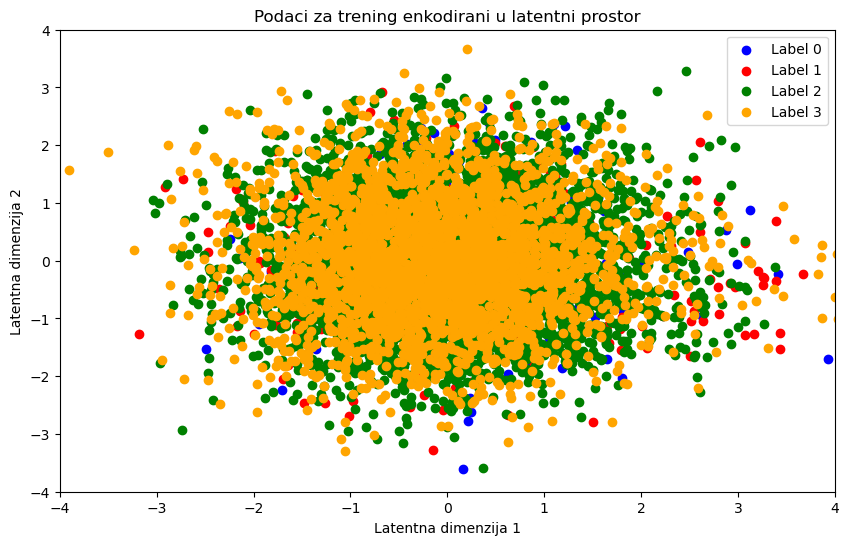

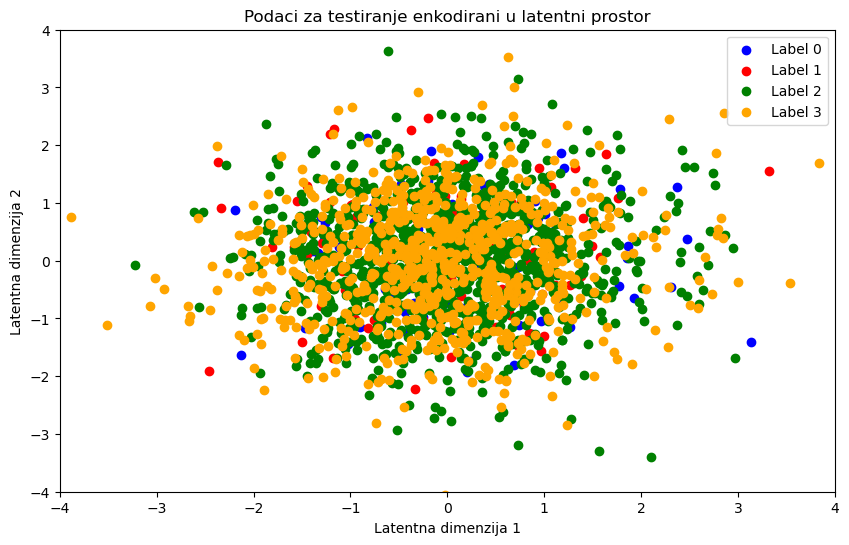

In [33]:
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

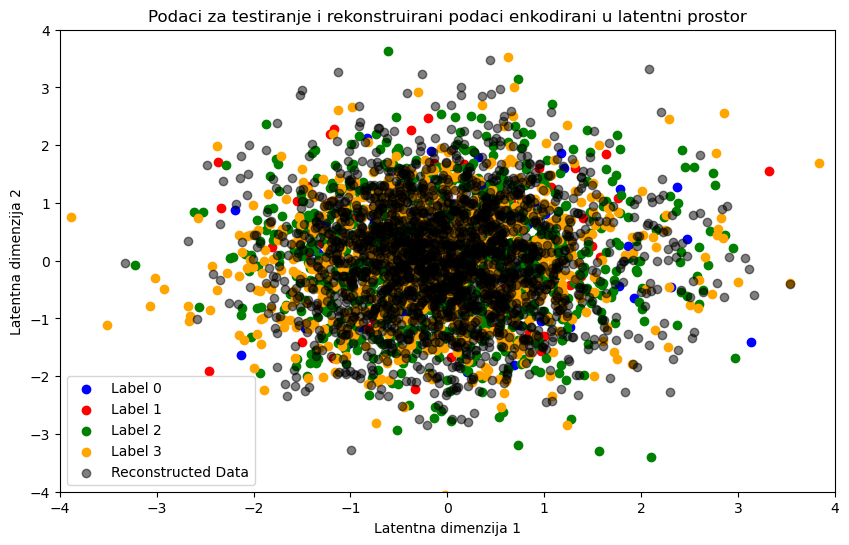

In [34]:
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plt.figure(figsize=(10, 6))
plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


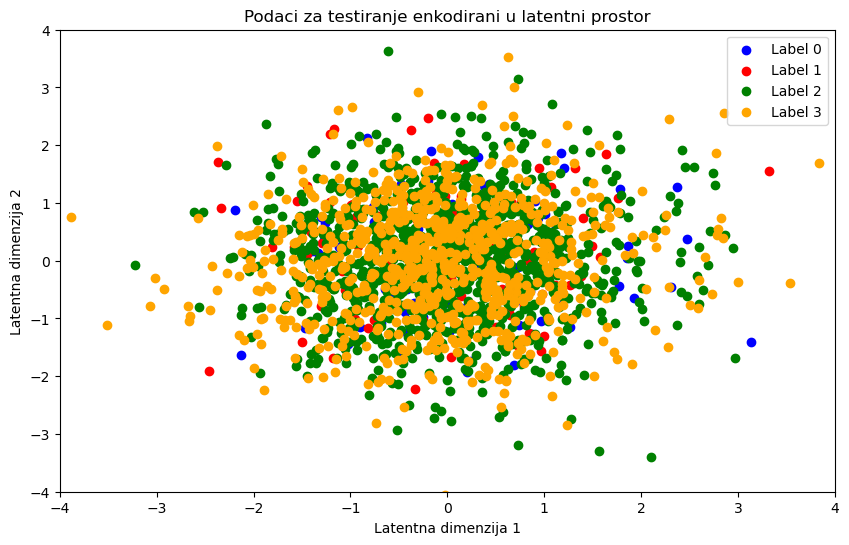

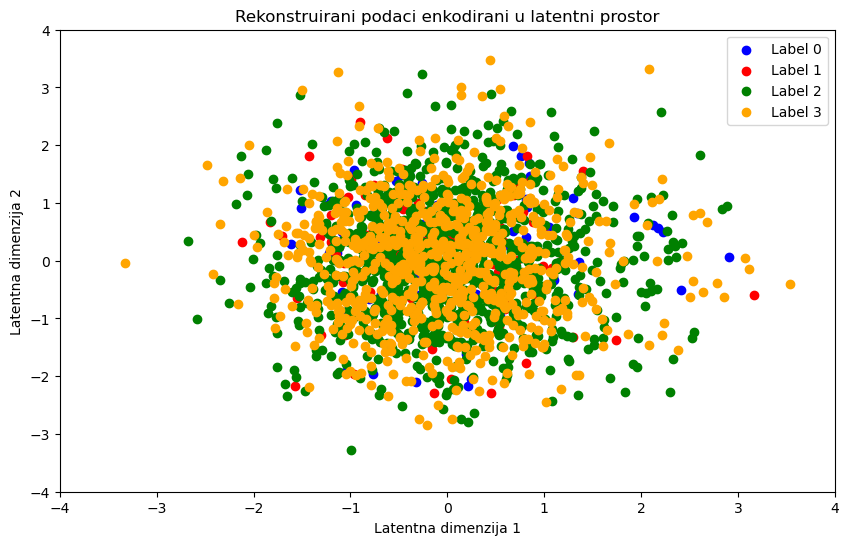

In [35]:
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

1/1 [==============================] - 0s 16ms/step


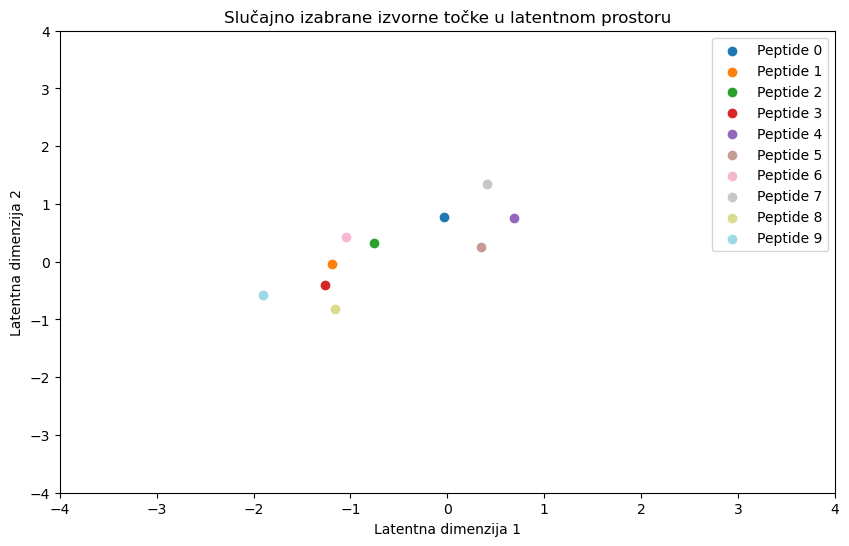

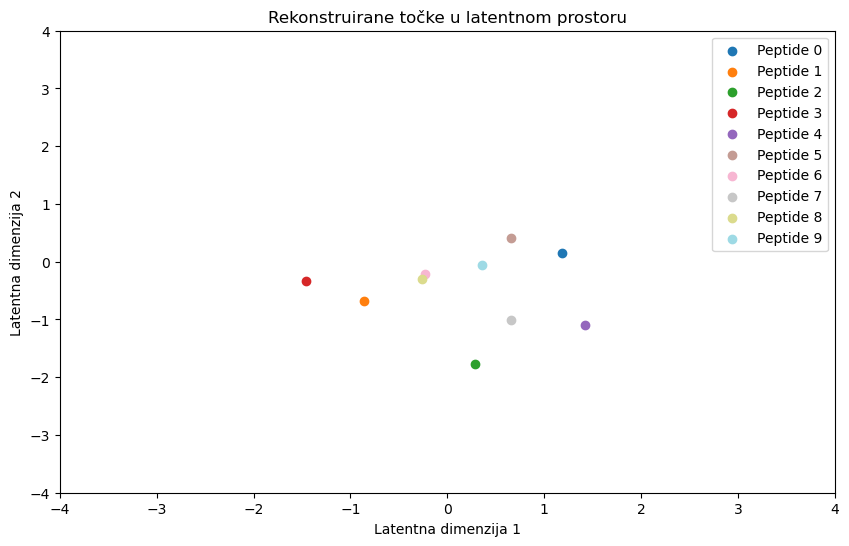

Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [1.3696673, 0.7253284, 2.3343003, 0.20705964, 2.0056567, 0.34087276, 1.0280731, 2.356585, 1.0475088, 2.3144078] 

Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka:  1.3729459762573242


In [36]:
selected_indices = np.random.choice(len(x_test), 10, replace=False)

selected_peptides = x_test[selected_indices]

_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)


def plot_selected_data(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    for i in range(num_peptides):
        plt.scatter(z_input[i, 0], z_input[i, 1], color=unique_colors[i], label=f'Peptide {i}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()

    
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))


plt.figure(figsize=(10, 6))
plt.title("Slučajno izabrane izvorne točke u latentnom prostoru")
plot_selected_data(encoded_selected_peptides)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirane točke u latentnom prostoru")
plot_selected_data(encoded_reconstructed_peptides)


distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
        
    distances.append(dist)

print("Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka: ", np.sum(distances)/10)

In [37]:
#NORMALIZIRANA UDALJENOST U LATENTNOM PROSTORU

min_values = np.min(z_test_input, axis=0)
max_values = np.max(z_test_input, axis=0)

# Calculate the diagonal length of the latent space
latent_space_size = np.linalg.norm(max_values - min_values)
#print(min_values, max_values)
print(latent_space_size)

distances_test = []

for i in range(len(x_test)):
    dist = euclidean_distance(z_test_input[i], reconstructed_z_test_encoded[i])
        
    distances_test.append(dist)

print("Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka: ", 
      np.sum(distances_test)/latent_space_size/len(x_test))

11.659506
Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka:  0.12132902856538674


In [38]:
#PEARSON
from scipy.stats import spearmanr, kendalltau, pearsonr

#print(x_test)
#print(reconstructed_z_test_input)

print(pearsonr(x_test.flatten(), reconstructed_z_test_input.flatten()))

PearsonRResult(statistic=0.7629994963375288, pvalue=0.0)


In [39]:
#RAZLIKA I RMSE

difference = x_test - reconstructed_z_test_input
print(np.abs(np.mean(difference)))

mse = np.mean(np.square(x_test - reconstructed_z_test_input))
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")


0.002577378883103217
RMSE: 0.0919707931157355


In [40]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [41]:
distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.21627517 0.         0.09658444 ... 0.28131756 0.22087143 0.10438595]
 [0.989762   0.9477572  0.94327205 ... 0.769564   0.9857153  0.9098678 ]
 [0.24094762 0.29326206 0.11527421 ... 0.4626286  0.18077497 0.12146298]
 ...
 [0.21628986 0.4850306  0.44914064 ... 0.79561895 0.20594077 0.5702549 ]
 [0.22212224 0.1442156  0.22567551 ... 0.37945053 0.24242498 0.26647243]
 [0.44624376 0.32650888 0.4143202  ... 0.3219005  0.46028036 0.39860505]]
[[0.6946996  0.5505019  0.6920356  ... 0.47955936 0.6724114  0.7946087 ]
 [0.6908274  0.7576919  0.41211903 ... 0.7314803  0.6151829  0.39704302]
 [0.2828293  0.36292472 0.26578447 ... 0.3311685  0.21243465 0.4797158 ]
 ...
 [0.29473144 0.38850778 0.23944548 ... 0.35831162 0.20922148 0.46216753]
 [0.3406007  0.34215328 0.3814037  ... 0.29795873 0.30952823 0.56308424]
 [0.27034065 0.33656153 0.29061142 ... 0.30366272 0.21770611 0.49451032]]


In [42]:
correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.11544299039406977 -0.09679170268074813
p-value: 5.026805470449888e-09 9.738711539058558e-07 

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.1761840274089013 -0.11949963176388748
p-value: 3.1685222759728286e-19 1.4201545178886773e-09 

Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.077873956894292 -0.06573468269125173
p-value: 4.317074586143327e-09 7.330950047380258e-07
